<a href="https://colab.research.google.com/github/ShubhamW248/AutoEncoders/blob/main/Anomaly_Detetction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder-based Anomaly Detection


In this notebook, we will train an autoencoder and variational autoencoders  for anomaly detection .

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, losses



In [10]:
# Load and preprocess the data
print("Loading and preprocessing the data...")
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")


Loading and preprocessing the data...
Data preprocessing complete.


In [11]:
# Define the Autoencoder model
def build_autoencoder(input_dim):
    encoder = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu')
    ])

    decoder = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(16,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_dim, activation='linear')
    ])

    autoencoder = models.Sequential([encoder, decoder])
    return autoencoder


In [12]:
# Define the VAE model
class VAE(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim, activation='linear')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar


In [13]:
# Train and evaluate Autoencoder
print("Training and evaluating Autoencoder...")
autoencoder = build_autoencoder(X_train_scaled.shape[1])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

autoencoder_recon = autoencoder.predict(X_test_scaled)
autoencoder_mse = np.mean(np.power(X_test_scaled - autoencoder_recon, 2), axis=1)
autoencoder_auc = roc_auc_score(y_test, autoencoder_mse)
print(f"Autoencoder ROC AUC: {autoencoder_auc:.4f}")


Training and evaluating Autoencoder...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Autoencoder ROC AUC: 0.9551


In [15]:
# Ensure input data is float32
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

# Define the VAE model with explicit float32 dtype
class VAE(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,), dtype=tf.float32),
            layers.Dense(32, activation='relu', dtype=tf.float32),
            layers.Dense(latent_dim + latent_dim, dtype=tf.float32)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(latent_dim,), dtype=tf.float32),
            layers.Dense(64, activation='relu', dtype=tf.float32),
            layers.Dense(input_dim, activation='linear', dtype=tf.float32)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar

# Train and evaluate VAE
print("Training and evaluating VAE...")
vae = VAE(X_train_scaled.shape[1], latent_dim=8)

@tf.function
def vae_loss(x, x_recon, mean, logvar):
    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=1))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1))
    return recon_loss + kl_loss

optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x_recon, mean, logvar = vae(x)
        loss = vae_loss(x, x_recon, mean, logvar)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

for epoch in range(50):
    for batch in tf.data.Dataset.from_tensor_slices(X_train_scaled).batch(256):
        train_step(batch)

vae_recon, _, _ = vae(X_test_scaled)
vae_mse = np.mean(np.power(X_test_scaled - vae_recon, 2), axis=1)
vae_auc = roc_auc_score(y_test, vae_mse)
print(f"VAE ROC AUC: {vae_auc:.4f}")

Training and evaluating VAE...
VAE ROC AUC: 0.9369


Plotting ROC curves...


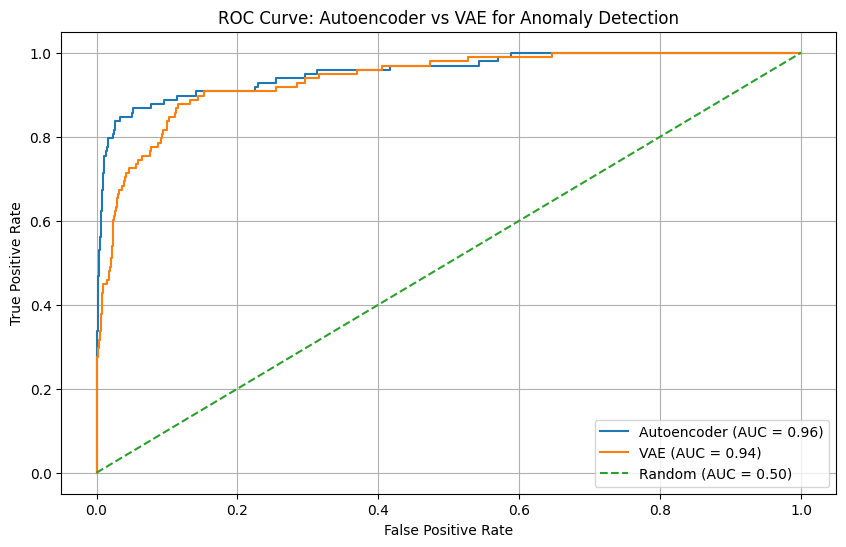

Autoencoder ROC AUC: 0.9551
VAE ROC AUC: 0.9369


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curves
print("Plotting ROC curves...")
def plot_roc_curve(y_true, y_score, label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    return roc_auc

plt.figure(figsize=(10, 6))
autoencoder_auc = plot_roc_curve(y_test, autoencoder_mse, 'Autoencoder')
vae_auc = plot_roc_curve(y_test, vae_mse, 'VAE')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Autoencoder vs VAE for Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()

print(f"Autoencoder ROC AUC: {autoencoder_auc:.4f}")
print(f"VAE ROC AUC: {vae_auc:.4f}")